In [53]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt

(171, 171, 3)

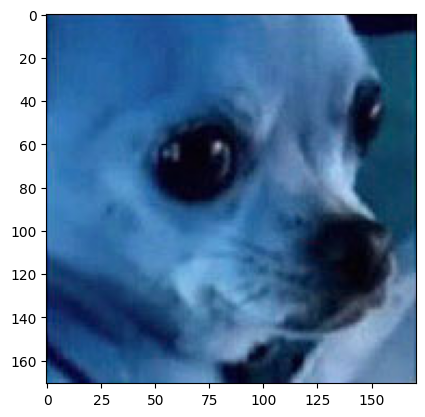

In [54]:
# Ler e visualizar imagem presente no dataset 
img = img = cv.imread("chihuahua-muffin/chihuahua/chihuahua-1.jpg")
plt.imshow(img)
img.shape

In [55]:
data_dir = "chihuahua-muffin"

img_height = 224
img_width = 224
batch_size = 32  

Found 16 files belonging to 2 classes.


Using 13 files for training.
Found 16 files belonging to 2 classes.
Using 3 files for validation.
Classes: ['chihuahua', 'muffin']


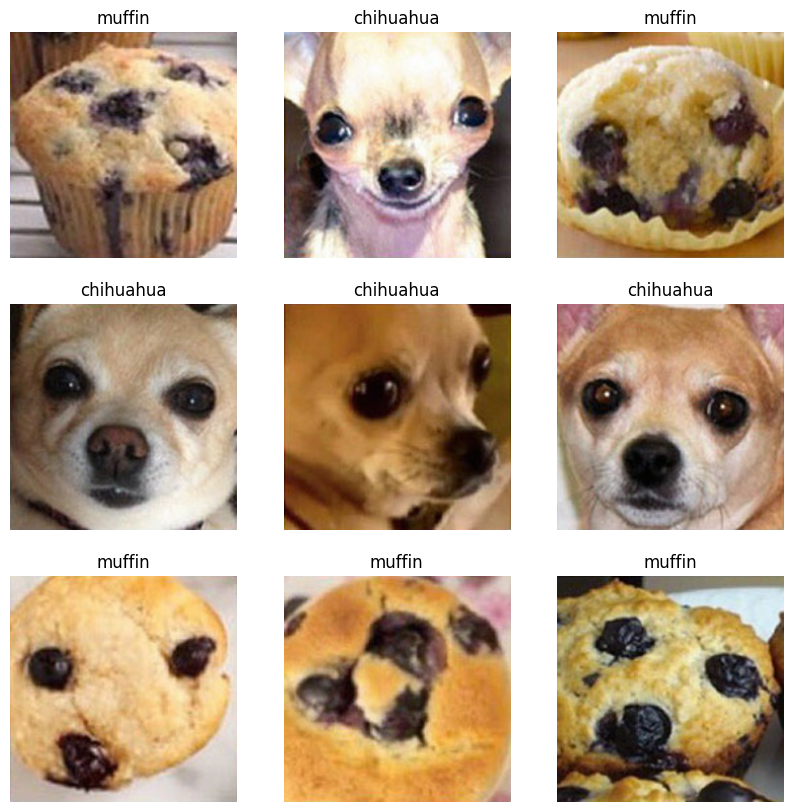

In [56]:
# Carregar os dados de treino e teste
train_ds = tf.keras.preprocessing.image_dataset_from_directory(  
    data_dir,
    validation_split=0.2,  
    subset="training",     
    seed=123,              
    image_size=(img_height, img_width),  
    batch_size=batch_size  
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Visualizar as classes
class_names = train_ds.class_names
print("Classes:", class_names)

# Visualizar as imagens do dataset com data augmentation e classes mapeadas para nomes
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [57]:
# Crie um gerador de imagens com técnicas de aumento de dados para o conjunto de treinamento
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crie um gerador de imagens apenas com reescala para o conjunto de validação (não aplicaremos aumento de dados a ele)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Carregue os dados de treinamento e de validação
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary' 
)

val_ds = val_datagen.flow_from_directory( 
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  
)

Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [63]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # 1 neuronio de sáidam geralmente é usado o numero de classes, entretanto como é um problema binário, usamos 1
])

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds
)

Epoch 1/30
1/1 [==============================] - 1s 587ms/step - loss: 0.6819 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 0s 330ms/step - loss: 0.7034 - accuracy: 0.4375 - val_loss: 0.6830 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 0s 298ms/step - loss: 0.6701 - accuracy: 0.5000 - val_loss: 0.6721 - val_accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 0s 294ms/step - loss: 0.6718 - accuracy: 0.6250 - val_loss: 0.6619 - val_accuracy: 0.7500
Epoch 5/30
1/1 [==============================] - 0s 294ms/step - loss: 0.6830 - accuracy: 0.3750 - val_loss: 0.6506 - val_accuracy: 0.7500
Epoch 6/30
1/1 [==============================] - 0s 297ms/step - loss: 0.6481 - accuracy: 0.6875 - val_loss: 0.6363 - val_accuracy: 0.8125
Epoch 7/30
1/1 [==============================] - 0s 291ms/step - loss: 0.6735 - accuracy: 0.6250 - val_loss: 0.6170 - val_accuracy: 0.8125
Epoch 8/30
1/1 [====

In [64]:
# Avaliar o modelo
model.evaluate(val_ds)

1/1 [==============================] - 0s 72ms/step - loss: 0.1133 - accuracy: 1.0000


[0.11327573657035828, 1.0]

In [65]:
# Salvar o modelo
model.save("model.h5")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [75]:
# Modelo até a camda que gera os vetores descritores das imagens
feature_extractor = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output
)

In [76]:
import os

# Função para extrair vetores descritores para uma imagem
def extract_descriptor(image_path):
    img = cv.imread(image_path)
    img = cv.resize(img, (224, 224))
    img = img / 255.0  
    img = np.expand_dims(img, axis=0)  
    descriptor = feature_extractor.predict(img)
    return descriptor.flatten()

# Dicionário para armazenar vetores descritores por classe
descriptor_database = {}

# Percorrer cada classe no conjunto de dados
for class_name in os.listdir(data_dir):
    if class_name == '.DS_Store' or class_name == 'full.jpg':
        continue
    class_dir = os.path.join(data_dir, class_name)
    descriptors = []

    # Percorrer cada imagem da classe
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        descriptor = extract_descriptor(img_path)
        descriptors.append(descriptor)

    # Armazenar vetores descritores da classe no dicionário
    descriptor_database[class_name] = descriptors

1/1 [==============================] - 0s 13ms/step


In [82]:
from IPython.display import Image, display

def euclidean_distance(descriptor1, descriptor2):
    return np.linalg.norm(descriptor1 - descriptor2)

def recognize_scores(descriptor, threshold=0.6, k=1):
    scores = []

    # Percorrer todas as classes no banco de dados
    for class_name, descriptors in descriptor_database.items():
        for stored_descriptor in descriptors:
            distance = euclidean_distance(descriptor, stored_descriptor)
            scores.append((class_name, distance))

    # Ordenar os resultados com base na distância (score)
    scores.sort(key=lambda x: x[1])

    # Selecionar os k melhores resultados
    top_k_results = scores[:k]

    # Verificar se o melhor resultado está abaixo do limite
    best_match = top_k_results[0][0]
    min_distance = top_k_results[0][1]
    if min_distance < threshold:
        result = best_match
    else:
        result = best_match

    return result, scores[:k]

1/1 [==============================] - 0s 19ms/step


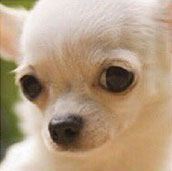

Resultado do Reconhecimento: chihuahua

Top 1 Melhores Resultados:
1. Classe: chihuahua, Score: 0.0


In [89]:
new_image_path = 'images_test/test.jpg'

# Extrair vetor descritor para a nova imagem
new_descriptor = extract_descriptor(new_image_path)

# Realizar o reconhecimento facial na nova imagem
result, top_k_scores = recognize_scores(new_descriptor)

# Exibir a imagem com o resultado e os k melhores scores
display(Image(filename=new_image_path))
print(f"Resultado do Reconhecimento: {result}")

# Exibir a lista dos k melhores scores
print(f"\nTop {len(top_k_scores)} Melhores Resultados:")
for i, (class_name, score) in enumerate(top_k_scores, start=1):
    print(f"{i}. Classe: {class_name}, Score: {score}")

1/1 [==============================] - 0s 17ms/step


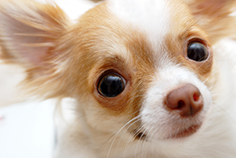

Resultado do Reconhecimento: chihuahua

Top 1 Melhores Resultados:
1. Classe: chihuahua, Score: 1.3981328010559082


In [90]:
new_image_path = 'images_test/chihuahua-closeup.jpg'

# Extrair vetor descritor para a nova imagem
new_descriptor = extract_descriptor(new_image_path)

# Realizar o reconhecimento facial na nova imagem
result, top_k_scores = recognize_scores(new_descriptor)

# Exibir a imagem com o resultado e os k melhores scores
display(Image(filename=new_image_path))
print(f"Resultado do Reconhecimento: {result}")

# Exibir a lista dos k melhores scores
print(f"\nTop {len(top_k_scores)} Melhores Resultados:")
for i, (class_name, score) in enumerate(top_k_scores, start=1):
    print(f"{i}. Classe: {class_name}, Score: {score}")

1/1 [==============================] - 0s 17ms/step


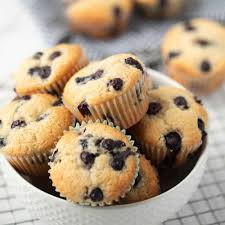

Resultado do Reconhecimento: muffin

Top 1 Melhores Resultados:
1. Classe: muffin, Score: 1.140898585319519


In [91]:
new_image_path = 'images_test/test2.jpeg'

# Extrair vetor descritor para a nova imagem
new_descriptor = extract_descriptor(new_image_path)

# Realizar o reconhecimento facial na nova imagem
result, top_k_scores = recognize_scores(new_descriptor)

# Exibir a imagem com o resultado e os k melhores scores
display(Image(filename=new_image_path))
print(f"Resultado do Reconhecimento: {result}")

# Exibir a lista dos k melhores scores
print(f"\nTop {len(top_k_scores)} Melhores Resultados:")
for i, (class_name, score) in enumerate(top_k_scores, start=1):
    print(f"{i}. Classe: {class_name}, Score: {score}")

1/1 [==============================] - 0s 16ms/step


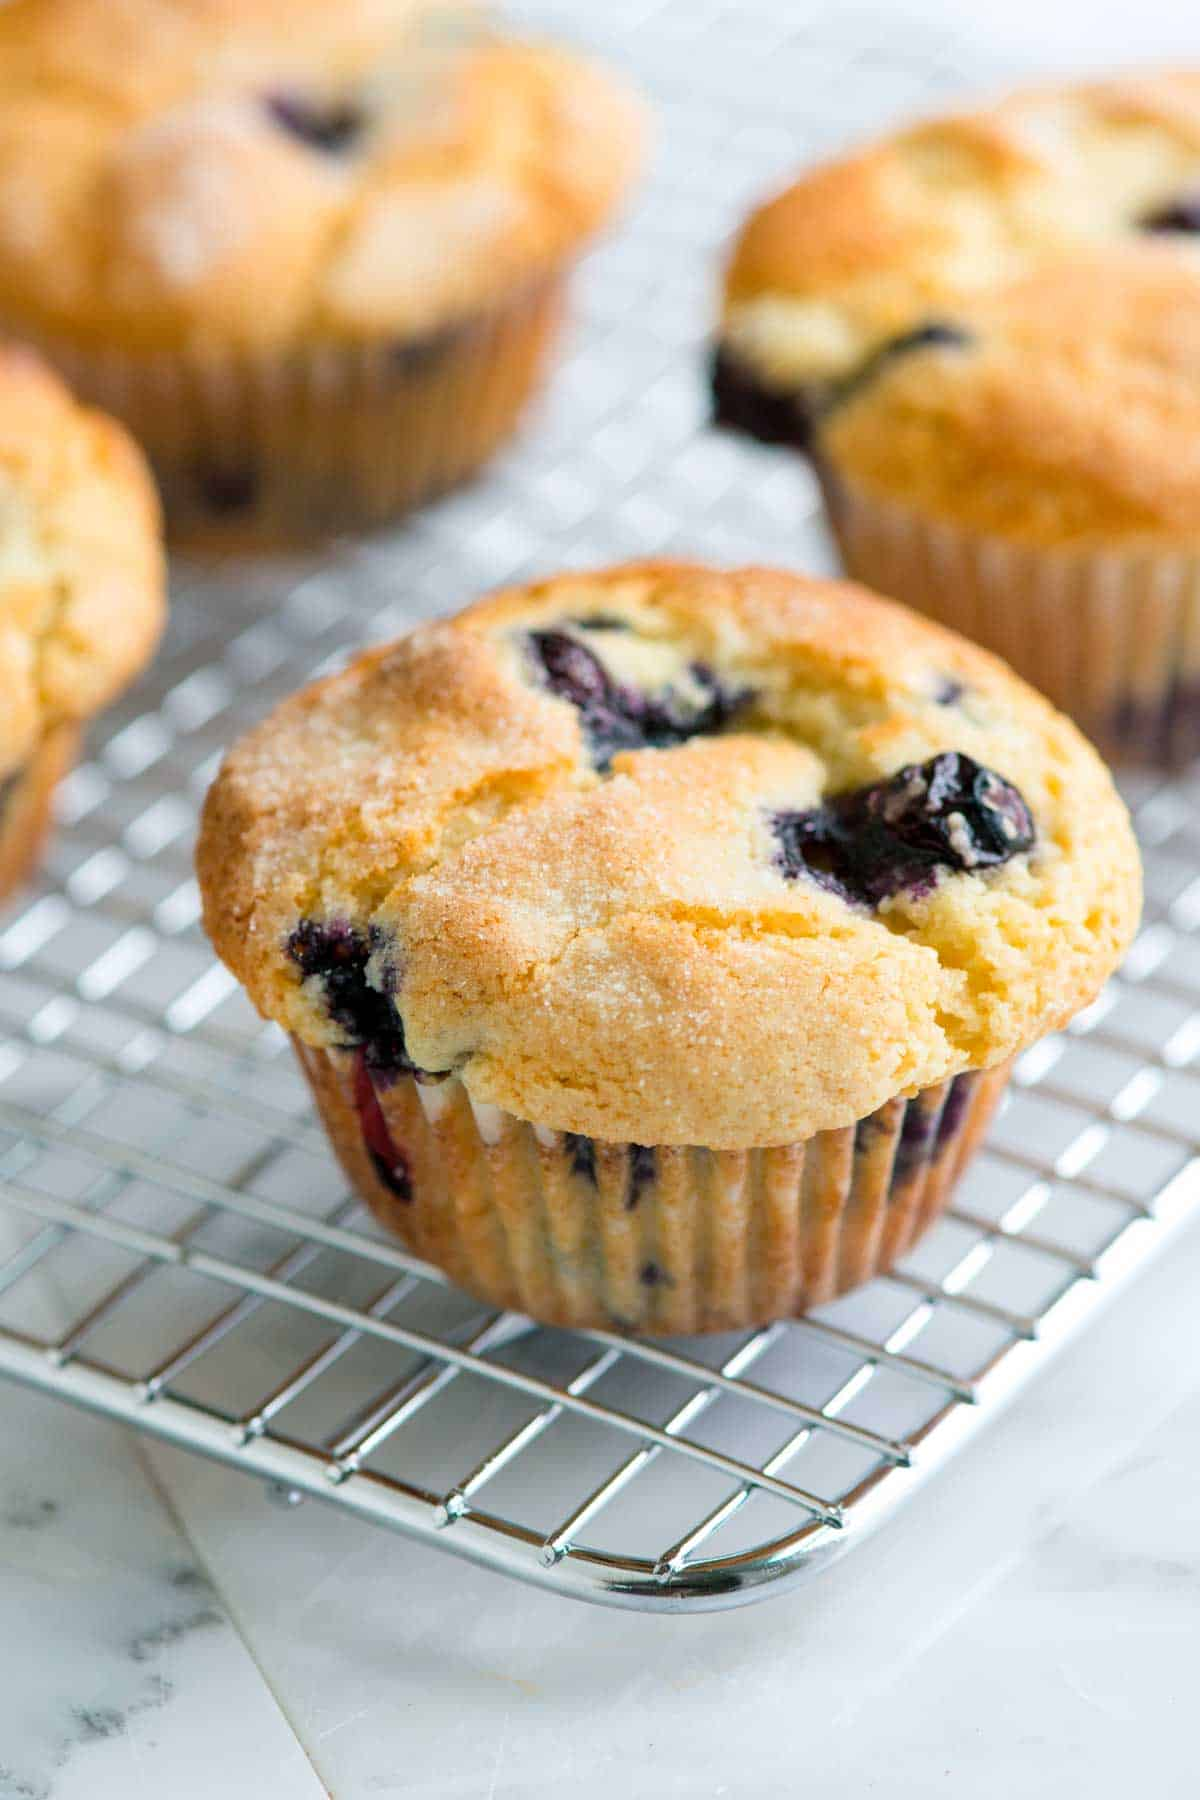

Resultado do Reconhecimento: muffin

Top 1 Melhores Resultados:
1. Classe: muffin, Score: 1.593187689781189


In [92]:
new_image_path = 'images_test/Blueberry-Muffin.jpg'

# Extrair vetor descritor para a nova imagem
new_descriptor = extract_descriptor(new_image_path)

# Realizar o reconhecimento facial na nova imagem
result, top_k_scores = recognize_scores(new_descriptor)

# Exibir a imagem com o resultado e os k melhores scores
display(Image(filename=new_image_path))
print(f"Resultado do Reconhecimento: {result}")

# Exibir a lista dos k melhores scores
print(f"\nTop {len(top_k_scores)} Melhores Resultados:")
for i, (class_name, score) in enumerate(top_k_scores, start=1):
    print(f"{i}. Classe: {class_name}, Score: {score}")